In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive/')
path_data = 'drive/My Drive/turtle_recall/images'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(path_data, transform= transform)

In [ ]:
# mean = 0.
# std = 0.
# nb_samples = 0.
# # Iterate over the images in the dataset
# for data, _ in dataset:
#     # Get the shape of the data tensor
#     shape = data.shape
#     # Flatten the tensor to a 1D array
#     data = data.view(data.size(0), -1)
#     # Calculate the mean and standard deviation of the pixel values
#     mean += data.mean(1)
#     std += data.std(1)
#     # Increment the sample count
#     nb_samples += data.size(0)

# # Calculate the mean and standard deviation of the entire dataset
# mean /= nb_samples
# std /= nb_samples

# # Print the results
# print("Mean:", mean)
# print("Standard deviation:", std)

In [ ]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ]
                               )


In [ ]:
dataset = torchvision.datasets.ImageFolder(path_data, transform=transform)

In [ ]:
# apply randomcrop for train set and centercrop for test

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [1006, 112])
train_set.transform = transforms.Compose([transforms.Resize(255),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ]
                               )

In [ ]:
# Create a data loader for the training set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)

# Create a data loader for the test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

# Create a dictionary of data loaders
dataloaders = {'train': train_loader, 'test': test_loader}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

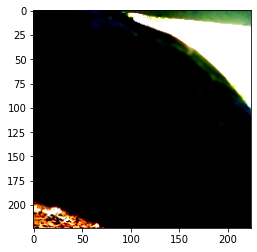

In [ ]:
plt.imshow(  images[7].permute(1, 2, 0))

In [ ]:
model_name = 'resnet'

# Number of classes in the dataset
num_classes = len(dataset.classes)
print(f"number of turtles: {num_classes}")

# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for
num_epochs = 50
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

number of turtles: 99


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      for phase in ['train', 'test']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):

                  if is_inception and phase == 'train':

                      outputs, aux_outputs = model(inputs)
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(aux_outputs, labels)
                      loss = loss1 + 0.4*loss2
                  else:
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)

                  _, preds = torch.max(outputs, 1)


                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

           
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


          if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'test':
              val_acc_history.append(epoch_acc)
    
    # Use the scheduler to adjust the learning rate
      # scheduler.step(epoch_loss)
      # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# let's start by initialising the model
!pip install timm
from timm import create_model
def initialize_model(num_classes, feature_extract, use_pretrained=True):

    # model_ft = models.resnet50(pretrained=use_pretrained)
    model_ft = create_model(
            "swin_tiny_patch4_window7_224", pretrained=True, num_classes=num_classes, in_chans=3
        )
    # set_parameter_requires_grad(model_ft, feature_extract)
    # num_ftrs = model_ft.fc.in_features
    # model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

print(model_ft)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.5 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1)

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1)

In [ ]:
#model_ft.fc = nn.Linear(512, num_classes)

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
device = 'cuda'
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Params to learn:
	 patch_embed.proj.weight
	 patch_embed.proj.bias
	 patch_embed.norm.weight
	 patch_embed.norm.bias
	 layers.0.blocks.0.norm1.weight
	 layers.0.blocks.0.norm1.bias
	 layers.0.blocks.0.attn.relative_position_bias_table
	 layers.0.blocks.0.attn.qkv.weight
	 layers.0.blocks.0.attn.qkv.bias
	 layers.0.blocks.0.attn.proj.weight
	 layers.0.blocks.0.attn.proj.bias
	 layers.0.blocks.0.norm2.weight
	 layers.0.blocks.0.norm2.bias
	 layers.0.blocks.0.mlp.fc1.weight
	 layers.0.blocks.0.mlp.fc1.bias
	 layers.0.blocks.0.mlp.fc2.weight
	 layers.0.blocks.0.mlp.fc2.bias
	 layers.0.blocks.1.norm1.weight
	 layers.0.blocks.1.norm1.bias
	 layers.0.blocks.1.attn.relative_position_bias_table
	 layers.0.blocks.1.attn.qkv.weight
	 layers.0.blocks.1.attn.qkv.bias
	 layers.0.blocks.1.attn.proj.weight
	 layers.0.blocks.1.attn.proj.bias
	 layers.0.blocks.1.norm2.weight
	 layers.0.blocks.1.norm2.bias
	 layers.0.blocks.1.mlp.fc1.weight
	 layers.0.blocks.1.mlp.fc1.bias
	 layers.0.blocks.1.mlp.fc2.wei

In [ ]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Early stoping is also a method for preventing overfitting
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min= 1e-4)

In [ ]:
import time
import copy
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 4.5117 Acc: 0.0358
test Loss: 4.4314 Acc: 0.0179
Epoch 1/49
----------
train Loss: 4.2253 Acc: 0.0775
test Loss: 4.1071 Acc: 0.0804
Epoch 2/49
----------
train Loss: 3.4089 Acc: 0.2177
test Loss: 3.5835 Acc: 0.1964
Epoch 3/49
----------
train Loss: 2.0712 Acc: 0.5547
test Loss: 3.2335 Acc: 0.2411
Epoch 4/49
----------
train Loss: 0.9189 Acc: 0.8618
test Loss: 2.8049 Acc: 0.3304
Epoch 5/49
----------
train Loss: 0.3777 Acc: 0.9742
test Loss: 2.6963 Acc: 0.3750
Epoch 6/49
----------
train Loss: 0.2176 Acc: 0.9881
test Loss: 2.5888 Acc: 0.4018
Epoch 7/49
----------
train Loss: 0.1253 Acc: 0.9980
test Loss: 2.5619 Acc: 0.3929
Epoch 8/49
----------
train Loss: 0.0953 Acc: 0.9990
test Loss: 2.5469 Acc: 0.4196
Epoch 9/49
----------
train Loss: 0.0945 Acc: 0.9950
test Loss: 2.5219 Acc: 0.4196
Epoch 10/49
----------
train Loss: 0.0635 Acc: 0.9970
test Loss: 2.6897 Acc: 0.4018
Epoch 11/49
----------
train Loss: 0.0616 Acc: 0.9980
test Loss: 2.6434 Acc: 0.4286
Ep